## Test PSF measurement in the stack

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


Make a couple of test images to test the PSF measurement on...

In [54]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

No module named utils
LSSTSW has not been set up.


See `pipe_tasks/examples/measurePsfTask.py`.

In [37]:
import lsst.pipe.tasks.measurePsf as measurePsf
import lsst.afw.table as afwTable
import lsst.ip.diffim as ipDiffim  # for detection - needs NaiveDipoleCentroid (registered by my routine)

exp = testObj.im1.asAfwExposure()
sources = dit.doDetection(exp, asDF=False)

In [39]:
config = measurePsf.MeasurePsfConfig()
schema = afwTable.SourceTable.makeMinimalSchema()

psfDeterminer = config.psfDeterminer.apply()
psfDeterminer.config.sizeCellX = 128
psfDeterminer.config.sizeCellY = 128
psfDeterminer.config.spatialOrder = 1
psfDeterminer.config.nEigenComponents = 3
task = measurePsf.MeasurePsfTask(schema=schema, config=config)

result = task.run(exp, sources)
psf = result.psf
cellSet = result.cellSet

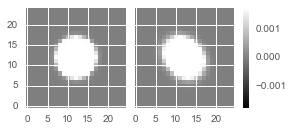

In [52]:
dit.plotImageGrid((testObj.im1.psf, testObj.im2.psf))

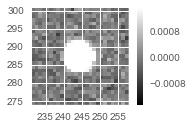

In [53]:
dit.plotImageGrid((psf.computeImage(),)) #, clim=(-0.001,0.001))

In [61]:
def measurePsf(exp):
    import lsst.pipe.tasks.measurePsf as measurePsf
    import lsst.afw.table as afwTable
    import lsst.ip.diffim as ipDiffim  # for detection - needs NaiveDipoleCentroid (registered by my routine)
    import lsst.meas.algorithms        as measAlg

    # The old (meas_algorithms) SdssCentroid assumed this by default if it
    # wasn't specified; meas_base requires us to be explicit.
    psf = measAlg.DoubleGaussianPsf(11, 11, 0.01)
    exp.setPsf(psf)

    im = exp.getMaskedImage().getImage()
    im -= np.median(im.getArray())

    sources = dit.doDetection(exp, asDF=False)
    config = measurePsf.MeasurePsfConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()

    psfDeterminer = config.psfDeterminer.apply()
    psfDeterminer.config.sizeCellX = 128
    psfDeterminer.config.sizeCellY = 128
    psfDeterminer.config.spatialOrder = 1
    psfDeterminer.config.nEigenComponents = 3
    task = measurePsf.MeasurePsfTask(schema=schema, config=config)

    result = task.run(exp, sources)
    return result

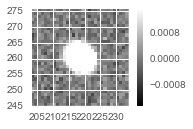

In [62]:
res = measurePsf(testObj.im2.asAfwExposure())
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

No module named utils
LSSTSW has not been set up.
(25, 25) (41, 41)
1.00000013607


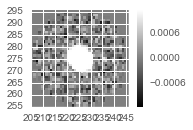

In [96]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='psfex')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

No module named utils
LSSTSW has not been set up.
(25, 25) (31, 31)
0.999945573135


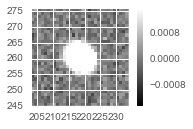

In [97]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='pca')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

See how it works on a *really* crowded field.

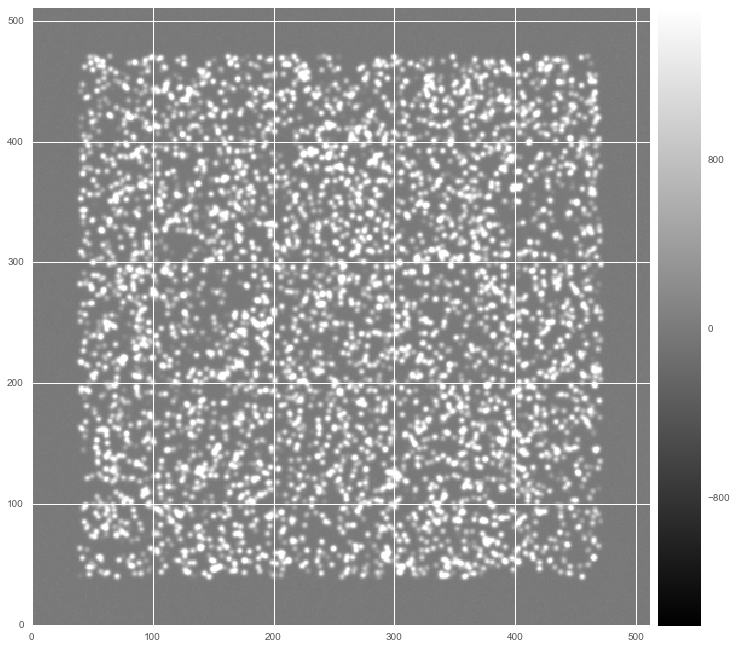

In [99]:
testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=5000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj2.im1.im,))

In [105]:
reload(dit)
res = dit.measurePsf(testObj2.im1.asAfwExposure(), measurePsfAlg='psfex')
psf1 = res.psf.computeImage()
print testObj2.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()

res = dit.measurePsf(testObj2.im2.asAfwExposure(), measurePsfAlg='psfex')
psf2 = res.psf.computeImage()
print testObj2.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()

No module named utils
LSSTSW has not been set up.
(25, 25) (41, 41)
0.999999589617
(25, 25) (41, 41)
0.999999644556


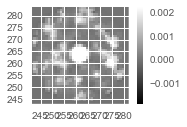

In [108]:
dit.plotImageGrid((psf1,)) #, clim=(-0.001,0.001))

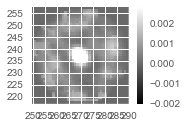

In [109]:
dit.plotImageGrid((psf2,)) #, clim=(-0.001,0.001))